In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import torch 
import numpy as np
import plotly
from torch import nn

In [2]:
df = pd.read_csv('IBM.csv')
print(df)

             Date         Low        Open   Volume        High       Close  \
0      02-01-1970   17.399618   17.423517   330536   17.483271   17.435469   
1      05-01-1970   17.495220   17.495220   443504   17.602772   17.602772   
2      06-01-1970   17.507170   17.602772   510448   17.638622   17.614723   
3      07-01-1970   17.507170   17.614723   479068   17.626673   17.626673   
4      08-01-1970   17.566921   17.626673   740568   17.662523   17.662523   
...           ...         ...         ...      ...         ...         ...   
13351  06-12-2022  146.699997  147.300003  2847600  147.800003  147.500000   
13352  07-12-2022  146.289993  147.330002  3971300  148.100006  147.270004   
13353  08-12-2022  147.369995  147.899994  2665700  149.149994  147.779999   
13354  09-12-2022  146.970001  147.399994  3047600  148.339996  147.050003   
13355  12-12-2022  146.942596  147.820007  1049947  148.279999  147.589996   

       Adjusted Close  
0            4.003040  
1            4.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13356 entries, 0 to 13355
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            13356 non-null  object 
 1   Low             13356 non-null  float64
 2   Open            13356 non-null  float64
 3   Volume          13356 non-null  int64  
 4   High            13356 non-null  float64
 5   Close           13356 non-null  float64
 6   Adjusted Close  13356 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 730.5+ KB


In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df.set_index('Date',inplace=True)

In [9]:
df.head()

,Low,Open,Volume,High,Close,Adjusted Close
Date,,,,,,
1970-02-01,17.399618,17.423517,330536,17.483271,17.435469,4.003040
1970-05-01,17.495220,17.495220,443504,17.602772,17.602772,4.041449
1970-06-01,17.507170,17.602772,510448,17.638622,17.614723,4.044193
1970-07-01,17.507170,17.614723,479068,17.626673,17.626673,4.046936
1970-08-01,17.566921,17.626673,740568,17.662523,17.662523,4.055170


In [10]:
df.tail()

,Low,Open,Volume,High,Close,Adjusted Close
Date,,,,,,
2022-06-12,146.699997,147.300003,2847600,147.800003,147.500000,147.500000
2022-07-12,146.289993,147.330002,3971300,148.100006,147.270004,147.270004
2022-08-12,147.369995,147.899994,2665700,149.149994,147.779999,147.779999
2022-09-12,146.970001,147.399994,3047600,148.339996,147.050003,147.050003
2022-12-12,146.942596,147.820007,1049947,148.279999,147.589996,147.589996


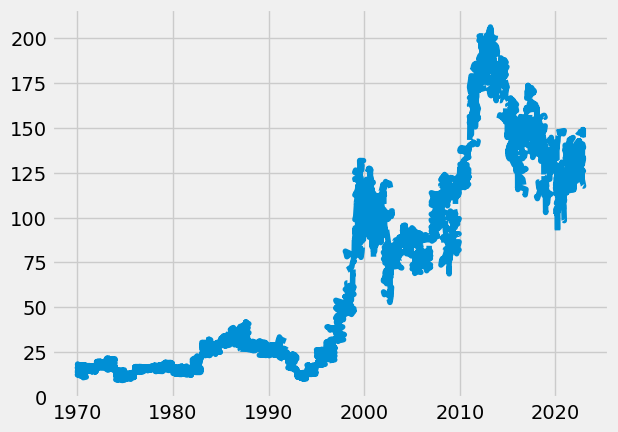

In [20]:
plt.plot(df['Close'], linestyle='--')
plt.show()

In [ ]:
class VanillaRNN(nn.Module): 
    
    def __init__(self, len_in, len_h, len_out):
        super(VanillaRNN, self).__init__()
        self.len_h = len_h #size of hidden state
        self.in_h = nn.Linear(len_in + len_h, len_h) #graph module to compute next hidden state 
        self.in_out = nn.Linear(len_in + len_h, len_out) #computes output 

    def forward(self, x, h):
        #here we choose to concatenate the hidden state and input 
        #another approach would be to multiply these vectors 
        combined = torch.cat((x, h), 1) 
        h_out = nn.Tanh(self.in_h(combined)) 
        #we choose to produce an output at each timestep
        y = self.in_out(combined) 
        return y, h_out 

    def init_h(self):
        #zero initialization 
        #alternatives include but not limited to Xavier/Kaiminh initialization
        return torch.zeros(1, self.len_h)

In [ ]:
def train(model, dataset, loss_function, optim, epochs, device):
    losses = [] #group losses for loss visualization 
    
    for epoch in range(epochs):
        print("Epoch %d / %d" % (epoch+1, epochs))
        print("-"*10)
    
        for i, (x, y) in enumerate(dataset):
            h_s = model.init_h() #initialize hidden state for each new sequence 
            for dp in dataset:
                y_pred, h_out = model('''Enter inputs here''')
            loss = loss_function(y_pred, y) 
            losses.append(loss)
        
            optim.zero_grad()
            loss.backward() #backprop 
            optim.step() #update weights

            if(i % 10):
              print("Step: {}/{}, current Epoch loss: {:.4f}".format(i, len(dataset), loss))  

#splits dataset into training and testing sets 
def test_train_split(df):
    
    mask = np.random.rand(len(df)) < 0.8
    train = df[mask]
    test = df[~mask]

    return train[['Date', 'Close']], test[['Date', 'Close']] 

def batched_data(df, n):
    x, y = [], []
    for i in range(len(df)-n):
        tmp = df[i:(i+n), :]
        x.append(tmp)
        y.append(df[i+n,:])
    return np.array(x), np.array(y)

In [ ]:
ibm_df = pd.read_csv('IBM.csv')
train_set, test_set = test_train_split(ibm_df)

x, y = batched_data(train_set, 10) # why am I doing this instead of building a dataloader from a dataset 

print(x)
print(y)

print(x.size)
print(y.size)